# Advanced Spatial Analysis: Spatial Autocorrelation

## Overview
In this lecture, we will learn spatial autocorrelation with two well-known methods: Moran's I and Local Indicator of Spatial Association (LISA). 
* **Global Moran's I** demonstrates how geographical phenomena are correlated over space, meaning whether closer things is more related than distant things. The method provides an index with the range -1 to 1; namely, -1 is a strong negative spatial autocorrelation and 1 is a strong positive spatial autocorrelation. 
* While Global Moran's I only provides one index to demonstrate spatial autocorrelation, **Local Indicator of Spatial Association (LISA)**, as known as Local Moran's I explains where high (i.e., HH Cluster) and low (LL Cluster) values are clustered. 

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import esda
import libpysal
import seaborn as sns
import warnings
import scipy
from tqdm import tqdm
warnings.filterwarnings('ignore')

## Spatial Autocorrelation: Global Moran's I

Spatial autocorrelation investigates how the geographical phenomena **are spatially related** to each other based on Tober's First Law of Geography; meaning that everything is usually related to all else but those which are near to each other are more related when compared to those that are further away. There are several indices that indicate the degree of spatial autocorrelation (e.g., Geary's C or Getis-Ord Gi*). Here, we study Moran's I, which is the most well-known method. 

$$I = \frac{n}{W} \frac{\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}(x_i - \overline{x})(x_j - \overline{x})}{\sum_{i=1}^{n}(x_i - \overline{x})^2}$$

where <br>
$n$ - the number of objects in space, <br>
$W$ - the sum of spatial weights, <br>
$w$ - a spatial weight for a pair of objects, <br>
$x_i, x_j$ - values of an attribute for objects i and j, <br>
$\overline{x}$ - a mean value of an attribute. <br>




In [2]:
# Census tract shapefile of Illinois
tract = gpd.read_file('./data/tl_2020_17_tract.shp')
tract = tract[['GEOID', 'geometry']]
tract = tract.loc[~tract['GEOID'].isin(['17031990000', '17097990000'])]
tract.head()

,GEOID,geometry
0,17031510300,"POLYGON ((-87.58745 41.72327, -87.58699 41.723..."
1,17031520100,"POLYGON ((-87.54292 41.72391, -87.54276 41.724..."
2,17097863006,"POLYGON ((-87.85621 42.29921, -87.85604 42.299..."
3,17097863004,"POLYGON ((-87.87635 42.30871, -87.87565 42.308..."
4,17097866200,"POLYGON ((-87.94467 42.24049, -87.94088 42.240..."


In [3]:
# ACS Household income data
income_table = pd.read_csv('./data/household_income.csv')
income_table['GEOID'] = income_table['GEOID'].astype(str)
income_table.head()

,GEOID,MeanIncome
0,17001000100,69254
1,17001000201,59810
2,17001000202,58677
3,17001000400,45784
4,17001000500,45510


In [4]:
# Join two dataframes 
income = tract.merge(income_table, on='GEOID')
income['MeanIncome'] = income['MeanIncome'].replace('-', '0') # Replace missing value with 0
income['MeanIncome'] = income['MeanIncome'].replace('N', '0') # Replace missing value with 0
income['MeanIncome'] = income['MeanIncome'].astype(int)
income.head()

,GEOID,geometry,MeanIncome
0,17031510300,"POLYGON ((-87.58745 41.72327, -87.58699 41.723...",48357
1,17031520100,"POLYGON ((-87.54292 41.72391, -87.54276 41.724...",66614
2,17097863006,"POLYGON ((-87.85621 42.29921, -87.85604 42.299...",0
3,17097863004,"POLYGON ((-87.87635 42.30871, -87.87565 42.308...",46815
4,17097866200,"POLYGON ((-87.94467 42.24049, -87.94088 42.240...",200459


In [5]:
# Select only Cook County
cook_income = income.loc[income['GEOID'].str.startswith('17031')]
cook_income = cook_income.to_crs(epsg=26971)
cook_income = cook_income.reset_index(drop=True)
cook_income

,GEOID,geometry,MeanIncome
0,17031510300,"POLYGON ((362062.513 561635.229, 362100.950 56...",48357
1,17031520100,"POLYGON ((365766.843 561739.371, 365779.696 56...",66614
2,17031590700,"POLYGON ((355068.939 573483.029, 355089.290 57...",75741
3,17031600400,"POLYGON ((357045.223 575151.355, 357065.402 57...",76109
4,17031824115,"POLYGON ((339952.529 551172.882, 339965.692 55...",81143
...,...,...,...
1326,17031283200,"POLYGON ((355753.370 578116.072, 355796.613 57...",97851
1327,17031100500,"POLYGON ((341167.507 589480.409, 341167.488 58...",102071
1328,17031801607,"POLYGON ((338475.272 602551.368, 338474.968 60...",157695
1329,17031804106,"POLYGON ((322350.545 601923.425, 322350.745 60...",139104


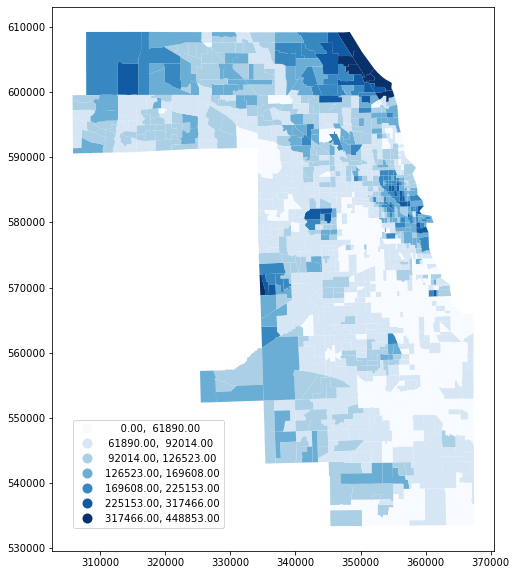

In [6]:
# Geographical distribution of Houshold Mean Income data
ax = cook_income.plot('MeanIncome', scheme='FisherJenks', k=7, cmap='Blues', figsize=(15, 10), legend=True)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.4, 0.25))

### Backbone of calculating Moran's I with Python

```python
import libpysal
import esda

## 1. Calculate weights (w) of geographical units
w = libpysal.weights.Queen() # based on Rook's case contiguity
w = libpysal.weights.Rook()  # based on Queen's case contiguity
w = libpysal.weights.DistanceBand() # based on a fixed distance

## 2. Define value to calculate spatial autocorrelation
y = df['MeanIncome']

## 3. Calculate the final index
mi = esda.moran.Moran(y, w_queen)
print(mi.I) # Moran's I value
print(mi.p_norm) # p-value of the current Moran's I 
print(mi.z_norm) # Z Score of the current Moran's I 

```

### Compute weigts of a geographical unit over the other geographical units
#### Based on contiguity: Rook's case and Queen's case

For more information, visit <a href=https://pysal.org/libpysal/generated/libpysal.weights.Queen.html>libpysal.weights.Queen</a> or <a href=https://pysal.org/libpysal/generated/libpysal.weights.Rook.html>libpysal.weights.Rook</a>.

(<Figure size 1440x720 with 2 Axes>, <AxesSubplot:>)

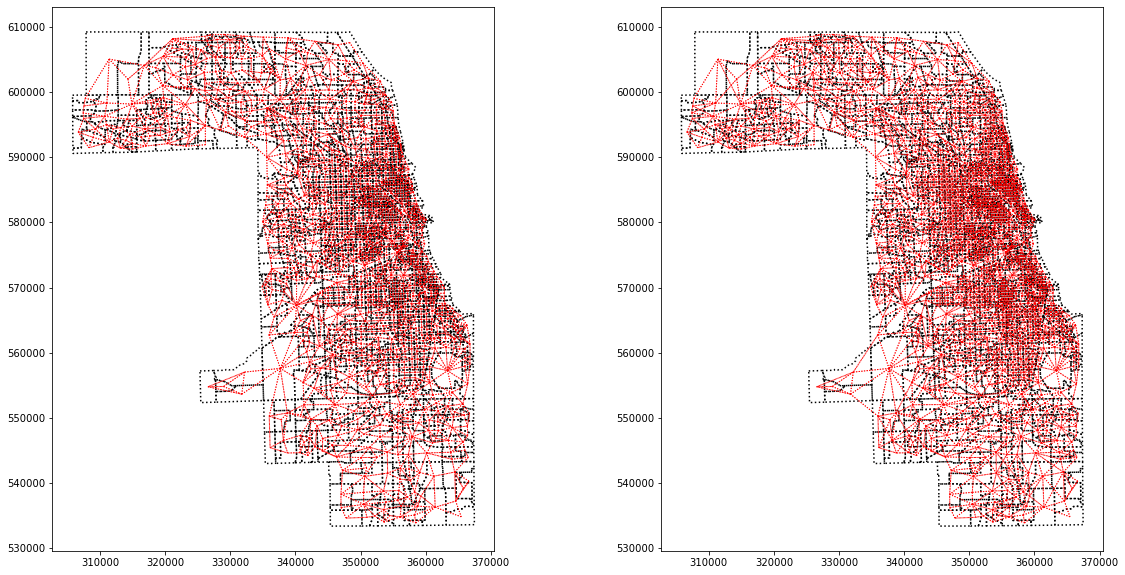

In [7]:
w_queen = libpysal.weights.Queen.from_dataframe(cook_income)
w_rook = libpysal.weights.Rook.from_dataframe(cook_income)

fig, axes = plt.subplots(1, 2, figsize=(20,10))

# Contiguity: Rook's case
cook_income.boundary.plot(ax=axes[0], ls=':', color='black')
w_rook.plot(cook_income, ax=axes[0], 
            edge_kws=dict(color='r', linestyle=':', linewidth=1),
            node_kws=dict(marker=''))

# Contiguity: Queen's case
cook_income.boundary.plot(ax=axes[1], ls=':', color='black')
w_queen.plot(cook_income, ax=axes[1], 
             edge_kws=dict(color='r', linestyle=':', linewidth=1),
             node_kws=dict(marker=''))

You can use `.neighbors` attribute to check the neighbor of each geographical unit and `.weights` attribute to check their weights. For contiguity, weights are automatically assigned to equal values. 

In [8]:
w_rook.neighbors

{0: [1169, 659, 820, 662, 663, 716, 766],
 1: [720, 628, 583, 718, 222],
 2: [1201, 418, 825, 13, 190],
 3: [161, 189, 15],
 4: [806, 1084, 854],
 5: [30, 984, 859, 184, 1295],
 6: [185, 667, 1231],
 7: [824, 1267, 327, 328, 699, 157],
 8: [864, 865, 930, 68, 836, 71, 72],
 9: [464, 1249, 887, 442, 93, 879],
 10: [1156, 1221, 268, 1104, 1045, 87, 893, 94],
 11: [387, 260, 1097, 1129, 267, 20, 52, 26, 1150],
 12: [770, 771, 505, 1178, 1323, 59],
 13: [336, 2, 825, 14, 15],
 14: [393, 394, 13, 190, 15],
 15: [336, 3, 394, 13, 14],
 16: [17, 339, 419, 917, 425],
 17: [16, 339, 421, 503, 61],
 18: [1056, 1073, 1074, 1076, 1077, 973],
 19: [20, 1127, 1128, 1129, 1146, 815],
 20: [19, 36, 52, 821, 853, 11, 815],
 21: [66, 932, 253, 1019, 252, 1020],
 22: [849, 119, 933, 966, 1301, 1118, 1119],
 23: [255, 383, 1134, 236, 254, 143],
 24: [308, 550, 551, 25, 1034],
 25: [724, 725, 325, 324, 24, 1034],
 26: [896, 258, 1097, 11, 267, 881, 948, 949, 1023],
 27: [1024, 321, 993, 992, 1227, 173, 350

In [9]:
w_rook.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],

Based on contiguity criteria, the list of neighbors is different.

In [10]:
w_rook.neighbors[1]

[720, 628, 583, 718, 222]

In [11]:
w_queen.neighbors[1]

[720, 1168, 628, 583, 222, 718, 719]

#### Calculate Moran's I

To calculate Moran's I, you can simply enter the attribute of interest (i.e., `MeanIncome`) and weight matrix (i.e., `w_rook` or `w_queen`) to <a href=https://pysal.org/esda/generated/esda.Moran.html>esda.moran.Moran()</a>.

In [12]:
y = cook_income['MeanIncome']

mi_rook = esda.moran.Moran(y, w_rook)
mi_queen = esda.moran.Moran(y, w_queen)
print(f"Moran's I with Rook's case contiguity: {round(mi_rook.I, 3)}, p-value: {round(mi_rook.p_norm, 3)}")
print(f"Moran's I with Queen's case contiguity: {round(mi_queen.I, 3)}, p-value: {round(mi_queen.p_norm, 3)}")

Moran's I with Rook's case contiguity: 0.744, p-value: 0.0
Moran's I with Queen's case contiguity: 0.73, p-value: 0.0


### Use of Fixed distance to calculate neighbors

The drawback of contiguity based neighbors is that they do not consider the distance decay for calculating weights. Here, we examine a way to incorporate a distance decay functions. 

The distance decay function in this package is as shown below. Here, alpha value should be negative. If the alpha value decreases, the distance decay becomes strong.

$$w_{ij} = d_{ij}^\alpha$$

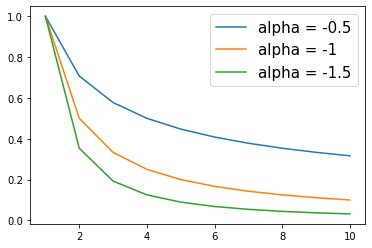

In [13]:
# The effect of the power on distance decay
x = np.linspace(1,10,10)
y_05 = [val**-0.5 for val in x]
y_1 = [val**-1 for val in x]
y_15 = [val**-1.5 for val in x]

plt.plot(x, y_05, label='alpha = -0.5')
plt.plot(x, y_1, label='alpha = -1')
plt.plot(x, y_15, label='alpha = -1.5')

plt.legend(fontsize=15)
plt.show()

In [14]:
cook_income

,GEOID,geometry,MeanIncome
0,17031510300,"POLYGON ((362062.513 561635.229, 362100.950 56...",48357
1,17031520100,"POLYGON ((365766.843 561739.371, 365779.696 56...",66614
2,17031590700,"POLYGON ((355068.939 573483.029, 355089.290 57...",75741
3,17031600400,"POLYGON ((357045.223 575151.355, 357065.402 57...",76109
4,17031824115,"POLYGON ((339952.529 551172.882, 339965.692 55...",81143
...,...,...,...
1326,17031283200,"POLYGON ((355753.370 578116.072, 355796.613 57...",97851
1327,17031100500,"POLYGON ((341167.507 589480.409, 341167.488 58...",102071
1328,17031801607,"POLYGON ((338475.272 602551.368, 338474.968 60...",157695
1329,17031804106,"POLYGON ((322350.545 601923.425, 322350.745 60...",139104


In [15]:
dist = 1000 # distance band
alpha_val = -1 # the power of distance decay function, should be negative value. 

# Obtain coordinates of each geographical units
coords = cook_income.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

# Calculate weights of each geographical units based on distance decay method. 
w = libpysal.weights.DistanceBand(data=list(coords), # coordinates of each geographical units
                                  threshold=dist, # distance band
                                  binary=False, # whether distance decay is employed or not. 
                                  alpha=alpha_val, # distance decay parameter for weight (default -1.0)
                                  silence_warnings=True
                                 )
print(w.weights[3])
print(w.neighbors[3])

[0.001348630678080076, 0.0017958546950827253, 0.002544590040188906, 0.0010428242333181486, 0.0010305112859906264, 0.0014554219866171455, 0.0010118734790642433]
[15, 161, 189, 394, 873, 1215, 1313]


In [16]:
w.neighbors

{0: [],
 1: [],
 2: [190, 1201],
 3: [15, 161, 189, 394, 873, 1215, 1313],
 4: [],
 5: [],
 6: [],
 7: [157, 328, 824],
 8: [68, 69, 70, 71, 72, 836, 865, 930],
 9: [93, 442, 464, 856, 868, 879, 887, 1249],
 10: [94, 268, 893, 1045, 1156, 1221, 1249],
 11: [260, 267, 387, 1129, 1150],
 12: [770, 1323],
 13: [14, 15, 336],
 14: [13, 15, 394],
 15: [3, 13, 14, 189, 336, 394, 1216],
 16: [17, 339, 419, 421, 753, 917],
 17: [16, 339, 421, 503],
 18: [87, 176, 862, 909, 973, 1056, 1073, 1074, 1075, 1076, 1077, 1156],
 19: [20, 1127, 1128, 1146],
 20: [19, 36, 52, 853, 1153],
 21: [252, 253, 852, 932, 1019, 1020, 1102],
 22: [119, 966, 1119],
 23: [236, 255, 383],
 24: [25, 550, 1034],
 25: [24, 724, 1034],
 26: [896, 948, 949, 950, 1022, 1023],
 27: [173, 174, 321, 992, 1024, 1227],
 28: [],
 29: [38, 48, 575, 576, 709, 1060],
 30: [],
 31: [193],
 32: [152, 174, 271, 381],
 33: [34, 166, 169],
 34: [33, 955],
 35: [171, 172, 993, 998, 999],
 36: [20, 52, 239, 242, 243, 387, 853, 957, 1153,

In [17]:
print(w_rook.neighbors[3])
print(w_queen.neighbors[3])

[161, 189, 15]
[336, 161, 394, 189, 15]


In [18]:
for i in w.neighbors[3]:
    print(i, cook_income.at[3, 'geometry'].centroid.distance(cook_income.at[i, 'geometry'].centroid))

15 741.4928462280051
161 556.8379238799915
189 392.9906131070771
394 958.93437076938
873 970.3920894361714
1215 687.0859511503683
1313 988.2658461656455


In [19]:
m = cook_income.loc[cook_income.index == 3].explore(color='black')
cook_income.loc[cook_income.index.isin(w.neighbors[3])].explore(m=m, color='blue')

In [20]:
temp_dist = cook_income.at[3, 'geometry'].centroid.distance(cook_income.at[15, 'geometry'].centroid)
print(f'Distance: {round(temp_dist)} meters, weight per distance decay: {temp_dist ** -1}')

Distance: 741 meters, weight per distance decay: 0.001348630678080076


In [21]:
# Calculate Moran's I
mi = esda.moran.Moran(y, w)

# Print results
print(mi.I) # Moran's I value
print(mi.p_norm) # p-value of the current Moran's I 
print(mi.z_norm) # Z Score of the current Moran's I 

print(f"Moran's I with {dist} meter radius: {round(mi.I, 3)}, p-value: {round(mi.p_norm, 3)}, z-score: {round(mi.z_norm, 3)}")

0.7096746068669993
0.0
25.268205436350318
Moran's I with 1000 meter radius: 0.71, p-value: 0.0, z-score: 25.268


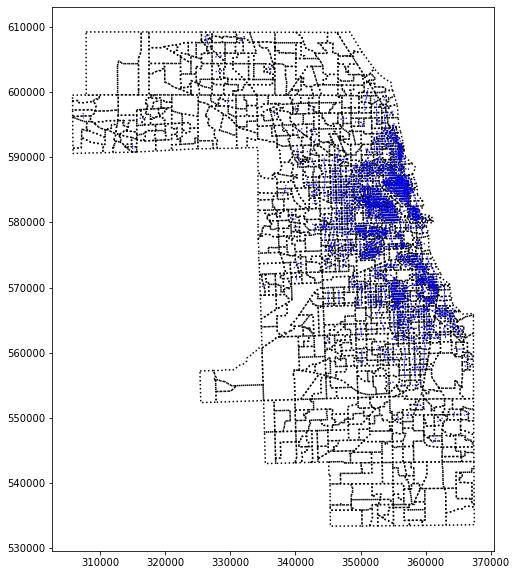

In [22]:
# Plot relationship between geographical units with a given distance band
fig, ax = plt.subplots(figsize=(10, 10))
cook_income.boundary.plot(ax=ax, ls=':', color='black')
w.plot(cook_income, ax=ax, 
       edge_kws=dict(color='blue', linestyle=':', linewidth=1),
       node_kws=dict(marker=''))

plt.show()

---
### *Exercise*

Here you will examine the sensitivity of Moran's I with **various threshold bandwidths and various alpha for distance decay**. Also, think about which combination of the weight of distance decay and threshold bandwidth provides the most statistically significant result. You can check <a href=https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/choosingdistanceband.htm>this website</a> for more information. <br>

The following codes are the backbone of spatial autocorrelation analysis. 

```python
# Your code here
dist = 3000 # threshold bandwidth
alpha_val = -1 # the power of distance decay function, should be negative value. 

# Obtain coordinates of each geographical units
coords = cook_income.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

# Calculate weights of each geographical units based on distance decay method. 
w = libpysal.weights.DistanceBand(data=list(coords), # coordinates of each geographical units
                                  threshold=dist, # threshold bandwidth
                                  binary=False, # whether distance decay is employed or not. 
                                  alpha=alpha_val, # distance decay parameter for weight (default -1.0)
                                  silence_warnings=True
                                 )
# Focused variable
y = cook_income['MeanIncome']

# Calculate Moran's I
mi = esda.moran.Moran(y, w)

# Print results
print(f"Moran's I with {dist} meter radius: {round(mi.I, 3)}, p-value: {round(mi.p_norm, 3)}, z-score: {round(mi.z_norm, 3)}")
```

---

In [25]:
# Your code here
dist = 3000 # threshold bandwidth
alpha_val = -1 # the power of distance decay function, should be negative value. 

# Obtain coordinates of each geographical units
coords = cook_income.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

# Calculate weights of each geographical units based on distance decay method. 
w = libpysal.weights.DistanceBand(data=list(coords), # coordinates of each geographical units
                                  threshold=dist, # threshold bandwidth
                                  binary=False, # whether distance decay is employed or not. 
                                  alpha=alpha_val, # distance decay parameter for weight (default -1.0)
                                  silence_warnings=True
                                 )
# Focused variable
y = cook_income['MeanIncome']

# Calculate Moran's I
mi = esda.moran.Moran(y, w)

# Print results
print(f"Moran's I with {dist} meter radius: {round(mi.I, 3)}, p-value: {round(mi.p_norm, 3)}, z-score: {round(mi.z_norm, 3)}")

Moran's I with 3000 meter radius: 0.657, p-value: 0.0, z-score: 58.281


## Local Indicators of Spatial Association (LISA): Local Moran's I

Moran's I is a characteristic of the complete spatial pattern and does not provide an indication of the location of the clusters. The concept of a local indicator of spatial association, or LISA was suggested in Anselin (1995) to remedie this situation. A LISA is seen as having two important characteristics. 
1. It provides a statistic for each location with an assessment of significance. 
2. It establishes a proportional relationship between the sum of the local statistics and a corresponding global statistic.

Source: https://geodacenter.github.io/workbook/6a_local_auto/lab6a.html <br>
Anselin, Luc. 1995. “Local Indicators of Spatial Association — LISA.” Geographical Analysis 27: 93–115.

<a href=https://pysal.org/esda/generated/esda.Moran_Local.html>esda.moran.Moran_Local</a> will help you calculate LISA. It returns two important information in `.q` attribute and `p_sim`. `.q` provides the indicator of each classification of LISA (1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'), and `p_sim` provide the p-value of each classification. 

In [26]:
# https://pysal.org/esda/generated/esda.Moran_Local.html
y = cook_income['MeanIncome']  # Focused Variable
w_rook = libpysal.weights.Rook.from_dataframe(cook_income) # Contiguity weight

lm_rook = esda.moran.Moran_Local(y, w_rook)
print(lm_rook.q) # Classification of LISA
print(lm_rook.p_sim) # Significance of each classification

[3 3 3 ... 1 1 1]
[0.038 0.005 0.154 ... 0.157 0.073 0.008]


In [27]:
lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}

lisa_rook = []
for idx in range(len(lm_rook.q)):
    if lm_rook.p_sim[idx] < 0.05:
        lisa_rook.append(lm_dict[lm_rook.q[idx]])
    else:
        lisa_rook.append('Not_Sig')
        
lisa_rook = pd.Series(lisa_rook)
cook_income['rook'] = lisa_rook
cook_income

,GEOID,geometry,MeanIncome,rook
0,17031510300,"POLYGON ((362062.513 561635.229, 362100.950 56...",48357,LL
1,17031520100,"POLYGON ((365766.843 561739.371, 365779.696 56...",66614,LL
2,17031590700,"POLYGON ((355068.939 573483.029, 355089.290 57...",75741,Not_Sig
3,17031600400,"POLYGON ((357045.223 575151.355, 357065.402 57...",76109,Not_Sig
4,17031824115,"POLYGON ((339952.529 551172.882, 339965.692 55...",81143,Not_Sig
...,...,...,...,...
1326,17031283200,"POLYGON ((355753.370 578116.072, 355796.613 57...",97851,Not_Sig
1327,17031100500,"POLYGON ((341167.507 589480.409, 341167.488 58...",102071,Not_Sig
1328,17031801607,"POLYGON ((338475.272 602551.368, 338474.968 60...",157695,Not_Sig
1329,17031804106,"POLYGON ((322350.545 601923.425, 322350.745 60...",139104,Not_Sig


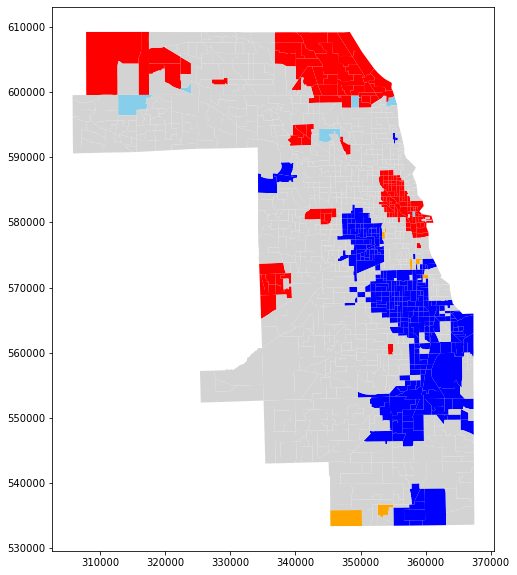

In [28]:
lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'lightgrey'}

fig, ax = plt.subplots(figsize=(10, 10))

for key in lisa_color.keys():
    cook_income.loc[cook_income['rook'] == key].plot(ax=ax, color=lisa_color[key], legend=True)

plt.show()

---
### *Exercise*

Let's investigate how the local indicators of spatial association (LISA) varies with different weight (i.e., queen's case contiguity and the fixed bandwidth of 10000). Utilize the codes mentioned above and create two maps of LISA. The following describes the steps you need to do.

* LISA with Queen's case contiguity 
1. Create contiguity with `libpysal.weights.Queens.from_dataframe()`.
2. Run `esda.moran.Moran_Local()` to obtain LISA with `.q` and `.p_sim` attribute. 
3. Select label (i.e., `.q`) with a certain significance in `.p_sim` attribute.
4. Display the result

* Lisa with Fixed Band Width (10000 feet)
1. Extract points coordinates from the GeoDataFrame.
2. Calculate weight with `libpysal.weights.DistanceBand()` method. 
3. Run `esda.moran.Moran_Local()` to obtain LISA with `.q` and `.p_sim` attribute. 
4. Select label (i.e., `.q`) with a certain significance in `.p_sim` attribute.
5. Display the result

Check out the following websites for more information.
* https://pysal.org/esda/generated/esda.Moran_Local.html
* https://pysal.org/libpysal/generated/libpysal.weights.Queen.html
* https://pysal.org/libpysal/generated/libpysal.weights.DistanceBand.html


In [ ]:
# Your code here with Queen's case





In [ ]:
# Your code here with Fixed bandwidth





In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for key in lisa_color.keys():
    cook_income.loc[cook_income['rook'] == key].plot(ax=axes[0], color=lisa_color[key], legend=True)
    cook_income.loc[cook_income['queen'] == key].plot(ax=axes[1], color=lisa_color[key], legend=True)
    cook_income.loc[cook_income['fixed'] == key].plot(ax=axes[2], color=lisa_color[key], legend=True)


for ax in axes:
    ax.get_xaxis().set_visible(False)  # Remove ticks and labels
    ax.get_yaxis().set_visible(False)  # Remove ticks and labels
    
axes[0].set_title("Rook's case", fontsize=15)
axes[1].set_title("Queen's case", fontsize=15)
axes[2].set_title("Fixed bandwidth", fontsize=15)

plt.show()

## Challenge: manually write codes for Moran's I

Here we want to challenge ourselves to write codes for calculating Moran's I. As mentioned earlier, the equation looks like the one below. 

$$I = \frac{n}{W} \frac{\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}(x_i - \overline{x})(x_j - \overline{x})}{\sum_{i=1}^{n}(x_i - \overline{x})^2}$$

where <br>
$n$ - the number of objects in space, <br>
$W$ - the sum of spatial weights, <br>
$w$ - a spatial weight for a pair of objects, <br>
$x_i, x_j$ - values of an attribute for objects i and j, <br>
$\overline{x}$ - a mean value of an attribute. <br>

It may sound very challenging, but you can achieve it by following the steps below. 
1. $\overline{x}$: Calculate the mean of the variable interested (Median income in our case). <br><br>
2. $(x_i - \overline{x})$: Calculate for each object a difference between single value and a mean. <br><br>
3. ${\sum_{i=1}^{n}(x_i - \overline{x})^2}$: Square each difference calculated at the previous step and to get a sum of these squares. <br><br>
4. $w_{ij} = d_{ij}^\alpha$: Calculate the distance decay of the pair locations based on the power of -1. <br><br>
5. $W = \sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}$: Sum the spatial weights. <br><br>
6. $\frac{n}{W}$: Simply divide the number of objects ($n$) by the sum of spatial weights ($W$). <br><br>
7. $\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}(x_i - \overline{x})(x_j - \overline{x})$: Finalize the numerator <br><br>
8. Combine all functions together. 


### Step 1 — 3

In [29]:
# Step 1
mean_score = cook_income['MeanIncome'].mean()
print(mean_score)

# Step 2
print(cook_income.at[0, 'MeanIncome'] - mean_score)

# Step 3

square_diff = 0
for i in range(cook_income.shape[0]):
    temp_value = (cook_income.at[i, 'MeanIncome'] - mean_score) ** 2
    square_diff += temp_value
    
print(square_diff)

95189.95717505635
-46832.95717505635
3839756251024.56


### Step 4 | $w_{ij} = d_{ij}^\alpha$

Let's calculate the distance decay of each pair of locations i and j, if the distance between two places is less than a threshold bandwidth. Suppose we want to formulate the data structure as shown below. 

```python
{i_1: {j_1: distance_decay_1,
       j_2: distance_decay_2,
       j_3: distance_decay_3,
       ...
     }
 ...
 i_87: {j_1: distance_decay_1,
        j_2: distance_decay_2,
        j_3: distance_decay_3,
        ...
       }
}

```

In [30]:
w_ = {}
dist = 5000
alpha = -1

for i in tqdm(range(cook_income.shape[0])):
    temp_dict = {}
    for j in range(cook_income.shape[0]):
        if i != j:
            temp_dist = cook_income.at[i, 'geometry'].centroid.distance(cook_income.at[j, 'geometry'].centroid)
            if temp_dist <= dist:
                temp_dict[j] = temp_dist ** alpha
                
    w_[i] = temp_dict
    

100%|██████████| 1331/1331 [03:12<00:00,  6.90it/s]


In [31]:
# Validation
coords = cook_income.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

# Calculate weights of each geographical units based on distance decay method. 
w = libpysal.weights.DistanceBand(data=list(coords), # coordinates of each geographical units
                                  threshold=dist, # threshold bandwidth
                                  binary=False, # whether distance decay is employed or not. 
                                  alpha=alpha, # distance decay parameter for weight (default -1.0)
                                  silence_warnings=True
                                 )
# print(w.neighbors[0])
# print(w.weights[0])

print(dict(zip(w.neighbors[0], w.weights[0])))
print("-------")
print(w_[0])

{1: 0.00026759678915502674, 65: 0.00022312123166006364, 97: 0.00024552410647376064, 98: 0.00027532608462111307, 126: 0.00023442542953268293, 146: 0.00022860669234032327, 147: 0.00020642669518497253, 148: 0.0002647770477071215, 149: 0.0003214819807626818, 181: 0.0002819360999224561, 182: 0.00024826061314678235, 213: 0.00021548973547801976, 221: 0.00021219383395909507, 222: 0.0003469406752459787, 286: 0.00035016344823409715, 309: 0.0002753127113992554, 368: 0.00027595625746561914, 456: 0.00022697851842533252, 496: 0.00020668221936498085, 542: 0.0002422502110178533, 543: 0.0003149555857760375, 544: 0.00027979444112114486, 545: 0.00033877461445860695, 583: 0.00021285439956925264, 588: 0.00034120193744763814, 589: 0.0002718499504385534, 626: 0.00030040990901816566, 627: 0.00028860985430480377, 628: 0.0003699577653619371, 659: 0.0004416437475351306, 660: 0.0004614256489350992, 661: 0.00040242113262778026, 662: 0.0005420597740971988, 663: 0.000707683698773629, 716: 0.0005357797371060601, 717:

In [32]:
from copy import deepcopy

In [33]:
# Calculate the portion of each distance decay value over the entire distance decay value
w__ = deepcopy(w_)

for i in tqdm(w_.keys()):
    for j in w_[i].keys():
        temp_sum = sum(list(w_[i].values()))
        w__[i][j] = w_[i][j] / temp_sum
#         print(i, j, w_[i][j], sum(w_[i].values()), w__[i][j])

100%|██████████| 1331/1331 [00:00<00:00, 6333.84it/s]


In [34]:
print(w_[0])
print("-------")
print(sum(w_[0].values()))
print("-------")
print(w__[0])
print("-------")
print(sum(w__[0].values()))

{1: 0.00026759678915502674, 65: 0.00022312123166006364, 97: 0.00024552410647376064, 98: 0.00027532608462111307, 126: 0.00023442542953268293, 146: 0.00022860669234032327, 147: 0.00020642669518497253, 148: 0.0002647770477071215, 149: 0.0003214819807626818, 181: 0.0002819360999224561, 182: 0.00024826061314678235, 213: 0.00021548973547801976, 221: 0.00021219383395909507, 222: 0.0003469406752459787, 286: 0.00035016344823409715, 309: 0.0002753127113992554, 368: 0.00027595625746561914, 456: 0.00022697851842533252, 496: 0.00020668221936498085, 542: 0.0002422502110178533, 543: 0.0003149555857760375, 544: 0.00027979444112114486, 545: 0.00033877461445860695, 583: 0.00021285439956925264, 588: 0.00034120193744763814, 589: 0.0002718499504385534, 626: 0.00030040990901816566, 627: 0.00028860985430480377, 628: 0.0003699577653619371, 659: 0.0004416437475351306, 660: 0.0004614256489350992, 661: 0.00040242113262778026, 662: 0.0005420597740971988, 663: 0.000707683698773629, 716: 0.0005357797371060601, 717:

In [35]:
# Reassign the standardized weights of distance decay
w_ = w__

### Step 5 | $W = \sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}$

In [36]:
W = 0
for i in range(len(cook_income)):
    for j in w_[i].keys():
#         print(i, j, w_[i][j])
        W += w_[i][j]
        
print(W)

1330.9999999999823


### Step 6 | $\frac{n}{W}$

In [37]:
n = cook_income.shape[0]

n/W

1.0000000000000133

### Step 7 | $\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}(x_i - \overline{x})(x_j - \overline{x})$

In [38]:
numerator = 0

for i in tqdm(range(cook_income.shape[0])):
    for j in w_[i].keys():
        diff_1 = cook_income.at[i, 'MeanIncome'] - mean_score
        diff_2 = cook_income.at[j, 'MeanIncome'] - mean_score
        
        numerator += w_[i][j] * diff_1 * diff_2
        
print(numerator)

100%|██████████| 1331/1331 [00:02<00:00, 602.20it/s]

2139069096404.1292


### Step 8: Finalize Moran's I 
$$I = \frac{n}{W} \frac{\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}(x_i - \overline{x})(x_j - \overline{x})}{\sum_{i=1}^{n}(x_i - \overline{x})^2}$$

In [39]:
I = (n/W) * (numerator / square_diff)
I

0.5570846055223925

In [40]:
# Validation

# Obtain coordinates of each geographical units
coords = cook_income.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

# Calculate weights of each geographical units based on distance decay method. 
w = libpysal.weights.DistanceBand(data=list(coords), # coordinates of each geographical units
                                  threshold=dist, # threshold bandwidth
                                  binary=False, # whether distance decay is employed or not. 
                                  alpha=alpha, # distance decay parameter for weight (default -1.0)
                                  silence_warnings=True
                                 )
# Focused variable
y = cook_income['MeanIncome']

# Calculate Moran's I
mi = esda.moran.Moran(y, w)

# Print results
print(mi.I) # Moran's I value
print(mi.p_norm) # p-value of the current Moran's I 
print(mi.z_norm) # Z Score of the current Moran's I 

print("---------------")
print(f"Moran's I with {dist} feet radius: {round(mi.I, 3)}, p-value: {round(mi.p_norm, 3)}, z-score: {round(mi.z_norm, 3)}")
print("---------------")



0.5570846055223859
0.0
77.92735832196031
---------------
Moran's I with 5000 feet radius: 0.557, p-value: 0.0, z-score: 77.927
---------------
